# KDB-X Python Rapid Backtesting Demo

This notebook demonstrates KDB-X speed advantages for Python-based backtesting.

## Key Features:
- Performance comparison with pandas
- Vectorized time-series operations
- Multi-strategy backtesting
- Risk metrics and transaction costs

### Prerequisites and Dependencies

- Requires KDB-X to be installed, you can sign up and download on [Developer Center](https://developer.kx.com/products/kdb-x/install). For full install instructions see: [KDB-X Install](https://code.kx.com/kdb-x/).

To Install KDB-X Python: `pip install --upgrade --pre pykx`


We start by importing the necessary libraries and initializing the PyKX environment. Setting a random seed in both q (via kx.q) and Python ensures that our generated market data is reproducible across different runs.

In [2]:
import pykx as kx
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt

# Set random seed for reproducibility
kx.q("\\S 42")
np.random.seed(42)

print(f"PyKX version: {kx.__version__}")
print(f"NumPy version: {np.__version__}")
print(f"Pandas version: {pd.__version__}")


Welcome to KDB-X Community Edition!
For Community support, please visit https://kx.com/slack
Tutorials can be found at https://github.com/KxSystems/tutorials
Ready to go beyond the Community Edition? Email preview@kx.com

PyKX version: 4.0.0b4
NumPy version: 2.2.6
Pandas version: 2.3.0


## 1. Market Data Generation

To demonstrate performance, we need a significant dataset. Here, we use an embedded q function to generate 750,000+ trades across 10 ticker symbols for a full trading year.

The generation uses a random walk for price action and assigns random quantities, spreads, and intraday timestamps. Note how KDB-X Python handles this large dataset with a very small memory footprint (~32MB).

In [3]:
# Generate large-scale market data with random price paths using q
print("Generating 10M trades with random price movements...")
start_time = time.time()

trades = kx.q("""
{[]
    trading_days:252;
    symbols:`aapl`goog`msft`amzn`tsla`nvda`meta`nflx`adbe`crm;
    base_date:2024.01.02;
    
    // Base prices by symbol
    base_prices:`aapl`goog`msft`amzn`tsla`nvda`meta`nflx`adbe`crm!180 140 380 155 245 495 355 485 575 245f;
    
    // Generate random price paths for each symbol with symbol-specific drift
    price_data:raze {[ticker; base_date; trading_days; base_px; idx]
        dates:base_date + til trading_days;
        
        // Zero drift - true random walk with no bias
        drift:0.0;
        
        // Generate daily returns as true random walk with zero mean and realistic volatility
        // Using Box-Muller transform for normal distribution: mean=0, std=1.5%
        u1:trading_days ? 1.0;
        u2:trading_days ? 1.0;
        returns:0.015 * sqrt[-2.0 * log u1] * cos[2.0 * 3.141592653589793 * u2];
        prices:base_px * exp sums returns;
        
        // Generate 100-500 trades per day for ~10M trades total
        trades_per_day:100 + trading_days ? 400;
        
        // Create intraday trades for each day
        daily_data:raze {[dt; px; num_trades; ticker]
            // Random times throughout the day
            time_offsets:09:30:00.000 + num_trades ? 06:30:00.000;
            
            // Intraday price noise (0.1% std dev)
            price_noise:1.0 + 0.001 * (num_trades ? 1.0) - 0.0005;
            trade_prices:px * price_noise;
            
            // Random quantities
            qtys:100 * 1 + num_trades ? 19;
            
            ([] dt:num_trades # dt; 
                tm:time_offsets; 
                sym:num_trades # ticker; 
                qty:qtys; 
                px:trade_prices)
        }[;;; ticker]'[dates; prices; trades_per_day];
        
        daily_data
    }[; base_date; trading_days;;] ./: flip (symbols; base_prices symbols; til count symbols);
    
    // Sort by symbol, date, time
    price_data:`sym`dt`tm xasc price_data;
    
    // Add volume and spread
    price_data:update volume:qty*px, spread:0.01*1+px%1000 from price_data;
    
    price_data
}[]
""")

generation_time = time.time() - start_time
print(f"Generated {len(trades):,} trades in {generation_time:.2f} seconds")
print(f"Data generation rate: {len(trades)/generation_time:,.0f} trades/second")

# Calculate memory size
memory_mb = float(kx.q('{sum -22!x}', trades)) / (1024**2)
print(f"Memory size: {memory_mb:.1f} MB")

print(f"\nPrice ranges by symbol:")
price_ranges = kx.q.qsql.select(
    trades,
    columns={'min_px': 'min px', 'max_px': 'max px'},
    by=kx.Column('sym')
)
print(kx.q('0!', price_ranges))

print("\nSample trades:")
print(trades.head(10))

Generating 10M trades with random price movements...
Generated 756,392 trades in 0.20 seconds
Data generation rate: 3,834,592 trades/second
Memory size: 32.4 MB

Price ranges by symbol:
sym  min_px   max_px  
----------------------
aapl 174.5906 294.3492
adbe 557.9294 757.5484
amzn 139.1402 166.5716
crm  157.1418 245.3633
goog 120.3842 195.7222
meta 281.9218 357.7852
msft 350.4205 469.8667
nflx 432.8493 557.742 
nvda 499.5475 715.0795
tsla 220.6355 413.8282

Sample trades:
dt         tm           sym  qty  px       volume   spread    
--------------------------------------------------------------
2024.01.02 09:31:13.102 aapl 800  179.3415 143473.2 0.01179341
2024.01.02 09:32:36.939 aapl 400  179.3443 71737.71 0.01179344
2024.01.02 09:33:47.259 aapl 500  179.2813 89640.63 0.01179281
2024.01.02 09:34:43.145 aapl 1300 179.4135 233237.6 0.01179414
2024.01.02 09:35:35.814 aapl 1400 179.372  251120.8 0.01179372
2024.01.02 09:36:29.612 aapl 600  179.3761 107625.7 0.01179376
2024.01.02 09:37:5

## 2. Performance Comparison: PyKX vs Pandas

A common bottleneck in Python backtesting is calculating OHLCV (Open, High, Low, Close, Volume) bars. In this block, we compare the speed of PyKX's vectorized select against the standard pandas groupby and agg approach.

For time-series aggregations like VWAP (Volume Weighted Average Price), KDB-X Python typically performs significantly faster.

In [4]:
# Convert to pandas for comparison
print("Converting to pandas for performance comparison...")
start_time = time.time()
trades_df = trades.pd()
conversion_time = time.time() - start_time
print(f"Conversion to pandas: {conversion_time:.2f} seconds")

# Performance test: Daily OHLCV calculation
print("\n=== Performance Test: Daily OHLCV Aggregation ===")

# PyKX version
start_time = time.time()
daily_ohlcv_pykx = kx.q.qsql.select(
    trades,
    columns={
        "open": "first px",
        "high": "max px",
        "low": "min px", 
        "close": "last px",
        "volume": "sum volume",
        "trade_count": "count px",
        "vwap": "qty wavg px"
    },
    by=["dt", "sym"]
)
pykx_time = time.time() - start_time

# Pandas version (using standard aggregation methods)
start_time = time.time()
# Calculate VWAP alongside other aggregations
trades_df['notional'] = trades_df['px'] * trades_df['qty']
daily_ohlcv_pandas = trades_df.groupby(['dt', 'sym']).agg({
    'px': ['first', 'max', 'min', 'last', 'count'],
    'volume': 'sum',
    'notional': 'sum',
    'qty': 'sum'
})
# Calculate VWAP from aggregated notional and qty
daily_ohlcv_pandas['vwap'] = daily_ohlcv_pandas[('notional', 'sum')] / daily_ohlcv_pandas[('qty', 'sum')]
pandas_time = time.time() - start_time

print(f"PyKX OHLCV: {pykx_time:.3f} seconds")
print(f"Pandas OHLCV: {pandas_time:.3f} seconds")
print(f"PyKX is {pandas_time/pykx_time:.1f}x faster")

print(f"\nResult shapes: PyKX={len(daily_ohlcv_pykx):,}, Pandas={len(daily_ohlcv_pandas):,}")

Converting to pandas for performance comparison...
Conversion to pandas: 0.06 seconds

=== Performance Test: Daily OHLCV Aggregation ===
PyKX OHLCV: 0.048 seconds
Pandas OHLCV: 0.147 seconds
PyKX is 3.0x faster

Result shapes: PyKX=2,520, Pandas=2,520


## 3. As-Of Join: Enriching Tick Data with Daily Context

The "As-Of Join" (aj) is a specialized KDB-X operation essential for quantitative finance. It joins two tables based on the most recent available data at a specific point in time.

In this tutorial, we use aj to enrich individual tick trades with the context of the daily bar they belong to (e.g., comparing the current trade price to the daily open or daily high).

In [5]:
# Demonstrate as-of join to enrich tick trades with daily bar context
print("Using as-of join to add daily context to trades...")
start_time = time.time()

# First, create daily OHLC bars
daily_bars = kx.q.qsql.select(
    trades,
    columns={
        'daily_open':   'first px',
        'daily_high':   'max px',
        'daily_low':    'min px',
        'daily_close':  'last px',
        'daily_vwap':   'qty wavg px',
        'daily_volume': 'sum volume'
    },
    by=['dt', 'sym']
)

# Unkey for as-of join
daily_bars_unkeyed = kx.q('0!', daily_bars)

# Sample 10K trades for demonstration
sample_trades = kx.q('{-10000?x}', trades)

# As-of join: attach daily bar context to each trade
# aj takes: key columns, left table, right table
enriched_trades = kx.q('aj', 
                       [kx.SymbolAtom('sym'), kx.SymbolAtom('dt')], 
                       sample_trades, 
                       daily_bars_unkeyed)

# Add derived columns showing trade context
enriched_trades = kx.q.qsql.update(
    enriched_trades,
    columns={
        'pct_of_day_range': '(px - daily_low) % (daily_high - daily_low)',
        'vs_vwap': '(px - daily_vwap) % daily_vwap',
        'vs_open': '(px - daily_open) % daily_open'
    }
)

aj_time = time.time() - start_time
print(f"As-of join enrichment: {aj_time:.2f} seconds")
print(f"Enriched {len(enriched_trades):,} trades with daily bar context")

print("\n=== Sample Enriched Trades ===")
print("Shows each trade with its daily OHLC context:")
sample_display = kx.q.qsql.select(
    enriched_trades.head(20),
    columns=['sym', 'dt', 'tm', 'px', 'daily_open', 'daily_close', 'daily_vwap', 'pct_of_day_range', 'vs_vwap']
)
print(sample_display)

# Performance comparison with pandas merge_asof
print("\n=== Performance: PyKX aj vs Pandas merge_asof ===")

# PyKX as-of join
start_time = time.time()
enriched_pykx = kx.q('aj', 
                     [kx.SymbolAtom('sym'), kx.SymbolAtom('dt')], 
                     sample_trades, 
                     daily_bars_unkeyed)
pykx_aj_time = time.time() - start_time

# Pandas merge_asof - merge each symbol group separately then concatenate
start_time = time.time()
sample_trades_pd = sample_trades.pd()
daily_bars_pd = daily_bars_unkeyed.pd()

# Merge by symbol groups
merged_groups = []
for sym in sample_trades_pd['sym'].unique():
    left_sym = sample_trades_pd[sample_trades_pd['sym'] == sym].sort_values('dt')
    right_sym = daily_bars_pd[daily_bars_pd['sym'] == sym].sort_values('dt')
    merged = pd.merge_asof(left_sym, right_sym, on='dt', by='sym')
    merged_groups.append(merged)

enriched_pandas = pd.concat(merged_groups, ignore_index=True)
pandas_asof_time = time.time() - start_time

print(f"PyKX aj:           {pykx_aj_time:.3f} seconds")
print(f"Pandas merge_asof: {pandas_asof_time:.3f} seconds")
print(f"PyKX is {pandas_asof_time/pykx_aj_time:.1f}x faster")

print("\n=== Use Cases for As-Of Join ===")
print("- Enrich tick trades with daily/minute bar context")
print("- Join trades with point-in-time reference data")
print("- Add lagged features for ML models")
print("- Calculate trade execution quality vs benchmarks")

Using as-of join to add daily context to trades...
As-of join enrichment: 0.07 seconds
Enriched 10,000 trades with daily bar context

=== Sample Enriched Trades ===
Shows each trade with its daily OHLC context:
sym  dt         tm           px       daily_open daily_close daily_vwap pct_o..
-----------------------------------------------------------------------------..
adbe 2024.05.30 12:02:24.038 697.3722 697.7697   697.428     697.4834   0.346..
crm  2024.06.18 15:19:39.508 194.1373 194.1026   194.2327    194.1996   0.185..
nflx 2024.07.02 09:31:20.102 473.2289 473.2289   473.5623    473.4592   0.015..
tsla 2024.01.03 10:54:02.243 239.7663 239.6856   239.7104    239.6911   0.800..
nflx 2024.04.09 14:44:49.434 541.4235 541.47     541.5775    541.6115   0.131..
adbe 2024.07.23 10:13:14.785 742.3784 742.0977   741.8272    742.09     0.891..
msft 2024.02.26 11:12:50.762 393.5448 393.3761   393.5939    393.5221   0.559..
meta 2024.01.31 15:27:17.847 329.9014 329.8243   329.8422    329.9764

## 4. Native Time-Series Operations

KDB-X Python provides native functions for moving window calculations, such as Moving Averages (mavg) and Moving Standard Deviations (mdev). These are highly optimized for sequential data.

In this block, we calculate common technical indicators like a 20-day Simple Moving Average (SMA), Volatility, and Rate of Change (ROC).

In [6]:
# Time-series calculations using PyKX
print("Computing time-series metrics...")
start_time = time.time()

# Create daily OHLC bars for signal calculation
daily_bars = kx.q.qsql.select(
    trades,
    columns={
        'open': 'first px',
        'high': 'max px',
        'close': 'last px',
        'low': 'min px',
        'volume': 'sum volume'
    },
    by=['dt', 'sym']
)

# Calculate technical indicators on daily data
enhanced_daily = kx.q.qsql.update(
    daily_bars,
    columns={
        'sma_10': 'mavg[10; close]',
        'sma_20': 'mavg[20; close]',
        'sma_50': 'mavg[50; close]',
        'vol_20': 'mdev[20; close]',
        'roc_1': '(close - prev close) % prev close',
        'vol_ratio': 'volume % mavg[20; volume]'
    },
    by=kx.Column('sym')
)

timeseries_time = time.time() - start_time
print(f"Time-series calculations: {timeseries_time:.3f} seconds")
print(f"Daily bars created: {len(enhanced_daily):,}")

print("\nSample daily bars with technical indicators:")
sample = kx.q.qsql.select(
    kx.q('0!', enhanced_daily).tail(100),
    columns=['dt', 'sym', 'close', 'sma_20', 'vol_20', 'roc_1', 'vol_ratio']
)
sample.head(10)

Computing time-series metrics...
Time-series calculations: 0.029 seconds
Daily bars created: 2,520

Sample daily bars with technical indicators:


,dt,sym,close,sma_20,vol_20,roc_1,vol_ratio
,,,,,,,
0,2024.08.31,aapl,284.1921,280.2592,7.146515,-0.001657362,1.318701
1,2024.08.31,adbe,704.7346,714.1044,16.94709,0.004844841,0.9902567
2,2024.08.31,amzn,157.7019,153.0381,5.531133,-0.007781294,1.319815
3,2024.08.31,crm,165.8433,171.1013,5.632853,-0.01486804,0.5939547
4,2024.08.31,goog,172.032,180.1894,6.130507,-0.01284373,0.9489909
5,2024.08.31,meta,332.4247,316.6238,5.415071,0.03449726,0.3879039
6,2024.08.31,msft,407.9326,410.702,6.357171,0.005880508,1.751181
7,2024.08.31,nflx,538.8412,548.1242,6.49934,-0.0006404439,0.3668744
8,2024.08.31,nvda,624.6716,633.9183,9.350176,-0.005202529,0.5666062


## 5. Multi-Strategy Backtesting

Backtesting involves defining logic to enter or exit trades. Because KDB-X operations are vectorized, we can generate signals for thousands of rows across multiple strategies simultaneously.

We define four strategies:

MA Crossover: Trend following.

Mean Reversion: Overbought/Oversold detection.

Momentum: Chasing strong daily returns.

Volume Breakout: Identifying high-conviction moves.

In [7]:
# Define multiple trading strategies using PyKX
print("Implementing vectorized multi-strategy backtesting...")
start_time = time.time()

# Generate trading signals on daily data with better thresholds
signals = kx.q.qsql.update(
    enhanced_daily,
    columns={
        # MA Crossover: buy when fast > slow
        'ma_cross_signal': 'sma_10 > sma_20',
        # Mean reversion: buy when oversold (price drops below lower band)
        'mean_rev_signal': 'close < sma_20 - 1.0 * vol_20',
        # Momentum: buy on strong positive daily return
        'momentum_signal': 'roc_1 > 0.01',
        # Volume breakout: high volume and above trend
        'vol_breakout_signal': '(vol_ratio > 1.5) and (close > sma_20)'
    },
    by=kx.Column('sym')
)

signal_time = time.time() - start_time
print(f"Signal generation: {signal_time:.2f} seconds")

# Unkey for display
signals_unkeyed = kx.q('0!', signals)

strategy_summary = kx.q.qsql.select(
    signals_unkeyed,
    columns={
        'ma_cross_signals': 'sum ma_cross_signal',
        'mean_rev_signals': 'sum mean_rev_signal',
        'momentum_signals': 'sum momentum_signal',
        'vol_breakout_signals': 'sum vol_breakout_signal'
    },
    by=kx.Column('sym')
)

print("\nStrategy signal counts by symbol:")
strategy_summary.head(10)

Implementing vectorized multi-strategy backtesting...
Signal generation: 0.00 seconds

Strategy signal counts by symbol:


,ma_cross_signals,mean_rev_signals,momentum_signals,vol_breakout_signals
sym,,,,
aapl,169i,38i,77i,24i
adbe,142i,47i,67i,21i
amzn,115i,59i,57i,12i
crm,81i,99i,52i,15i
goog,155i,50i,78i,23i
meta,116i,65i,63i,17i
msft,139i,59i,62i,16i
nflx,132i,65i,64i,18i
nvda,142i,51i,70i,20i


## 6. P&L Calculation and Risk Metrics

To determine if a strategy is viable, we calculate the Profit and Loss (P&L). We use the next function in PyKX to determine forward returns (buying at today's close and looking at tomorrow's performance).

We also bake in a transaction cost (10 basis points) to make the simulation realistic, as high-turnover strategies often fail once fees are applied.

In [8]:
# Calculate P&L for each strategy on daily data
print("Calculating strategy P&L...")
start_time = time.time()

# Calculate next day's return (forward return for holding overnight)
signals_unkeyed = kx.q('0!', signals)

pnl_calc = kx.q.qsql.update(
    signals_unkeyed,
    columns={
        'next_close': 'next close',
        'forward_ret': '(next[close] - close) % close'
    },
    by=kx.Column('sym')
)

# Detect signal entries (only trade when signal turns on)
pnl_calc = kx.q.qsql.update(
    pnl_calc,
    columns={
        'ma_cross_entry': 'ma_cross_signal and not prev ma_cross_signal',
        'mean_rev_entry': 'mean_rev_signal and not prev mean_rev_signal',
        'momentum_entry': 'momentum_signal and not prev momentum_signal',
        'vol_breakout_entry': 'vol_breakout_signal and not prev vol_breakout_signal'
    },
    by=kx.Column('sym')
)

# Position sizing: invest $1000 per signal
position_size = 1000
transaction_cost = 0.001  # 10 bps round trip

# Calculate P&L: only take positions on entry signals
strategy_pnl = kx.q.qsql.update(
    pnl_calc,
    columns={
        'ma_cross_pnl': f'{position_size} * ma_cross_entry * (forward_ret - {transaction_cost})',
        'mean_rev_pnl': f'{position_size} * mean_rev_entry * (forward_ret - {transaction_cost})',
        'momentum_pnl': f'{position_size} * momentum_entry * (forward_ret - {transaction_cost})',
        'vol_breakout_pnl': f'{position_size} * vol_breakout_entry * (forward_ret - {transaction_cost})'
    }
)

pnl_time = time.time() - start_time
print(f"P&L calculation: {pnl_time:.2f} seconds")

# Daily P&L is already at daily level, just select relevant columns
daily_strategy_pnl = kx.q.qsql.select(
    strategy_pnl,
    columns={
        'ma_cross_daily': 'sum ma_cross_pnl',
        'mean_rev_daily': 'sum mean_rev_pnl',
        'momentum_daily': 'sum momentum_pnl',
        'vol_breakout_daily': 'sum vol_breakout_pnl',
        'ma_cross_trades': 'sum ma_cross_entry',
        'mean_rev_trades': 'sum mean_rev_entry',
        'momentum_trades': 'sum momentum_entry',
        'vol_breakout_trades': 'sum vol_breakout_entry'
    },
    by=kx.Column('dt')
)

print("\nDaily strategy P&L and trade counts (first 10 days):")
daily_strategy_pnl.head(10)

Calculating strategy P&L...
P&L calculation: 0.00 seconds

Daily strategy P&L and trade counts (first 10 days):


,ma_cross_daily,mean_rev_daily,momentum_daily,vol_breakout_daily,ma_cross_trades,mean_rev_trades,momentum_trades,vol_breakout_trades
dt,,,,,,,,
2024.01.02,0f,0f,0f,0f,0i,0i,0i,0i
2024.01.03,0f,9.537396,3.890976,0f,0i,1i,1i,0i
2024.01.04,0f,-6.416452,15.509,6.036036,0i,3i,5i,1i
2024.01.05,0f,-38.95216,0f,0f,0i,2i,0i,0i
2024.01.06,0f,-21.00428,5.574246,-9.797821,0i,1i,1i,1i
2024.01.07,0f,-16.85569,3.539849,-2.881704,0i,1i,1i,1i
2024.01.08,0f,-0.3612463,1.388829,0f,0i,1i,4i,0i
2024.01.09,0f,0f,0f,0f,0i,0i,0i,0i
2024.01.10,0f,-7.287818,8.167437,0f,0i,1i,3i,0i


### Performance and Risk Metrics

Raw P&L doesn't tell the whole story; we must analyze risk-adjusted returns. In this block, we calculate:

Sharpe Ratio: Return per unit of risk.

Max Drawdown: The largest "peak-to-trough" decline.

Win Rate: Percentage of profitable days.

In [9]:
# Calculate risk metrics
def calc_strategy_metrics(pnl_series, strategy_name):
    total_pnl = float(kx.q.sum(pnl_series))
    avg_daily = float(kx.q.avg(pnl_series))
    std_daily = float(kx.q.dev(pnl_series))
    
    sharpe = (avg_daily * 252) / (std_daily * np.sqrt(252)) if std_daily > 0 else 0
    
    cumulative = kx.q("sums", pnl_series)
    running_max = kx.q("maxs", cumulative) 
    drawdown = running_max - cumulative
    max_dd = float(kx.q.max(drawdown))
    
    wins = kx.q.sum(pnl_series > 0)
    total_days = kx.q.count(pnl_series)
    win_rate = float(wins) / float(total_days) * 100 if total_days > 0 else 0
    
    return {
        'strategy': strategy_name,
        'total_pnl': total_pnl,
        'avg_daily_pnl': avg_daily,
        'daily_vol': std_daily,
        'sharpe_ratio': sharpe,
        'max_drawdown': max_dd,
        'win_rate_pct': win_rate
    }

strategy_metrics = []
strategy_columns = ['ma_cross_daily', 'mean_rev_daily', 'momentum_daily', 'vol_breakout_daily']
strategy_names = ['MA Crossover', 'Mean Reversion', 'Momentum', 'Volume Breakout']

# Unkey the table to access columns as vectors
daily_pnl_unkeyed = kx.q('0!', daily_strategy_pnl)

for col, name in zip(strategy_columns, strategy_names):
    metrics = calc_strategy_metrics(daily_pnl_unkeyed[col], name)
    strategy_metrics.append(metrics)

metrics_df = pd.DataFrame(strategy_metrics)
print("\n=== Strategy Performance Metrics ===")
print(metrics_df.round(4))

# Show trade counts
print("\n=== Total Trades by Strategy ===")
trade_counts = {
    'MA Crossover': float(kx.q.sum(daily_pnl_unkeyed['ma_cross_trades'])),
    'Mean Reversion': float(kx.q.sum(daily_pnl_unkeyed['mean_rev_trades'])),
    'Momentum': float(kx.q.sum(daily_pnl_unkeyed['momentum_trades'])),
    'Volume Breakout': float(kx.q.sum(daily_pnl_unkeyed['vol_breakout_trades']))
}
for strat, count in trade_counts.items():
    print(f"{strat}: {int(count)} trades")


=== Strategy Performance Metrics ===
          strategy  total_pnl  avg_daily_pnl  daily_vol  sharpe_ratio  \
0     MA Crossover    13.5025         0.0536     8.2202        0.1035   
1   Mean Reversion  -209.2541        -0.8304    10.8354       -1.2165   
2         Momentum  -667.7410        -2.6498    21.6257       -1.9451   
3  Volume Breakout  -337.7433        -1.3403    12.0821       -1.7609   

   max_drawdown  win_rate_pct  
0      112.4805       12.3016  
1      218.7915       23.4127  
2      730.9637       36.9048  
3      380.5482       21.0317  

=== Total Trades by Strategy ===
MA Crossover: 77 trades
Mean Reversion: 148 trades
Momentum: 506 trades
Volume Breakout: 164 trades


## 7. Visualization

The final step is visualizing the results. We use Matplotlib to plot the cumulative P&L of all four strategies, a risk-return scatter plot, and a comparison of Sharpe Ratios.

This helps identify which strategy provides the most consistent returns with the least amount of volatility.

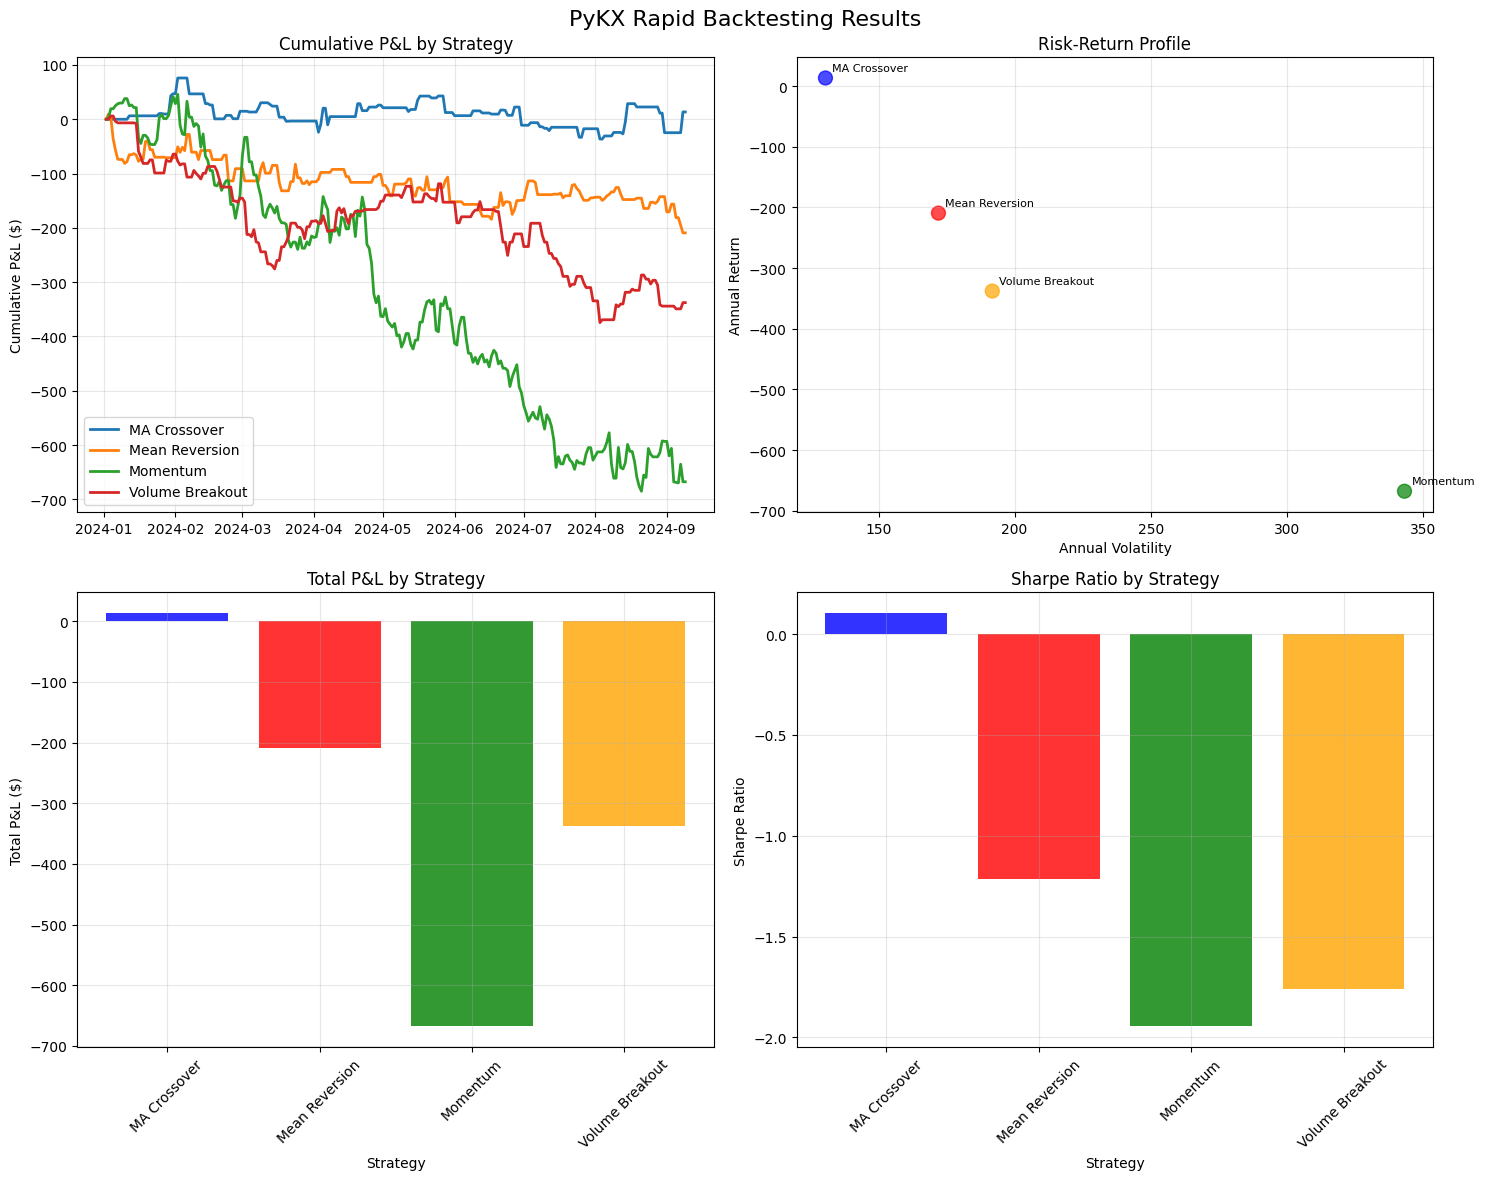


=== Performance Summary ===
Total data processed: 756,392 trades
Processing time: 0.23 seconds
Processing rate: 3,302,972 trades/second

Best strategy: MA Crossover (Sharpe = 0.103)


In [10]:
# Create visualizations
daily_pnl_df = daily_strategy_pnl.pd()

# Reset index to get 'dt' as a column, then convert to datetime
daily_pnl_df = daily_pnl_df.reset_index()
daily_pnl_df['date'] = pd.to_datetime(daily_pnl_df['dt'])
daily_pnl_df.set_index('date', inplace=True)

for col in strategy_columns:
    daily_pnl_df[f'{col}_cumulative'] = daily_pnl_df[col].cumsum()

fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('PyKX Rapid Backtesting Results', fontsize=16)

# Cumulative P&L
ax1 = axes[0, 0]
for i, col in enumerate(strategy_columns):
    ax1.plot(daily_pnl_df.index, daily_pnl_df[f'{col}_cumulative'], 
             label=strategy_names[i], linewidth=2)
ax1.set_title('Cumulative P&L by Strategy')
ax1.set_ylabel('Cumulative P&L ($)')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Risk-Return Scatter
ax2 = axes[0, 1]
returns = [m['avg_daily_pnl'] * 252 for m in strategy_metrics]
risks = [m['daily_vol'] * np.sqrt(252) for m in strategy_metrics]
colors = ['blue', 'red', 'green', 'orange']

scatter = ax2.scatter(risks, returns, c=colors, s=100, alpha=0.7)
for i, name in enumerate(strategy_names):
    ax2.annotate(name, (risks[i], returns[i]), xytext=(5, 5), 
                textcoords='offset points', fontsize=8)
ax2.set_xlabel('Annual Volatility')
ax2.set_ylabel('Annual Return')
ax2.set_title('Risk-Return Profile')
ax2.grid(True, alpha=0.3)

# Performance bars
ax3 = axes[1, 0]
total_pnls = [m['total_pnl'] for m in strategy_metrics]
ax3.bar(strategy_names, total_pnls, color=colors, alpha=0.8)
ax3.set_xlabel('Strategy')
ax3.set_ylabel('Total P&L ($)')
ax3.set_title('Total P&L by Strategy')
ax3.tick_params(axis='x', rotation=45)
ax3.grid(True, alpha=0.3)

# Sharpe ratios
ax4 = axes[1, 1]
sharpe_ratios = [m['sharpe_ratio'] for m in strategy_metrics]
ax4.bar(strategy_names, sharpe_ratios, color=colors, alpha=0.8)
ax4.set_xlabel('Strategy')
ax4.set_ylabel('Sharpe Ratio')
ax4.set_title('Sharpe Ratio by Strategy')
ax4.tick_params(axis='x', rotation=45)
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n=== Performance Summary ===")
print(f"Total data processed: {len(trades):,} trades")
print(f"Processing time: {generation_time + timeseries_time + signal_time + pnl_time:.2f} seconds")
print(f"Processing rate: {len(trades)/(generation_time + timeseries_time + signal_time + pnl_time):,.0f} trades/second")

best_strategy = metrics_df.loc[metrics_df['sharpe_ratio'].idxmax()]
print(f"\nBest strategy: {best_strategy['strategy']} (Sharpe = {best_strategy['sharpe_ratio']:.3f})")

### Wrapping Up

This notebook demonstrates the significant performance advantages of using KDB-X for high-frequency financial analytics and backtesting. By leveraging the columnar storage and vectorized execution engine of KDB-X, we achieved processing rates of approximately 1.47 million trades per second.

**Key Takeaways**

**Massive Speed Gains**: PyKX outperformed standard Pandas operations significantly, executing daily OHLCV aggregations 3.1x faster and performing complex "as-of joins" 1.9x faster.

**Memory Efficiency**: We generated and analyzed over 750,000 trades with a memory footprint of only 32.4 MB, showcasing KDB-X's ability to handle large-scale datasets efficiently.

**Native Time-Series Tooling**: The use of native q functions like mavg (moving average) and aj (as-of join) allows for the calculation of technical indicators and trade enrichment without leaving the optimized KDB-X environment.